In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using Device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random Seed locked to: {seed}")

set_seed(42) 

Random Seed locked to: 42


In [3]:
def download_stock_data(ticker, start_date, end_date):
    """Downloads historical stock data from Yahoo Finance."""
    print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if df.empty:
            print(f"No data found for ticker {ticker}.")
            return None
        # Flatten MultiIndex columns if they exist (common in new yfinance versions)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        print("Data download complete.")
        return df
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

# Test it immediately
TICKER = '^NSEI' # Nifty 50         
raw_df = download_stock_data(TICKER, '2010-01-01', '2026-01-17')
raw_df.head()

[*********************100%***********************]  1 of 1 completed

Data download complete.


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,5232.200195,5238.450195,5167.100098,5200.899902,0
2010-01-05,5277.899902,5288.350098,5242.399902,5277.149902,0
2010-01-06,5281.799805,5310.850098,5260.049805,5278.149902,0
2010-01-07,5263.100098,5302.549805,5244.750000,5281.799805,0
2010-01-08,5244.750000,5276.750000,5234.700195,5264.250000,0


In [4]:
# --- CELL 3: Universal Feature Engineering (Ensemble Ready) ---
def create_features_ensemble(df_input):
    df = df_input.copy()
    
    # 1. Target: 5-Day Forward Return Direction
    # 1 if price is higher in 5 days, 0 otherwise
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = (df['Close'].shift(-5) > df['Close']).astype(int)
    
    # 2. Volatility Regime (The "Panic Switch")
    # Short-term vol vs Long-term vol. High ratio = Crash likely.
    df['Vol_20'] = df['Log_Ret'].rolling(20).std()
    df['Vol_200'] = df['Log_Ret'].rolling(200).std()
    df['Vol_Ratio'] = df['Vol_20'] / df['Vol_200']
    
    # 3. Efficiency (Fractal Dimension Proxy)
    # 1.0 = Straight line trend, 0.0 = Random chop
    df['Efficiency'] = df['Close'].diff(20).abs() / df['Close'].diff(1).abs().rolling(20).sum()
    
    # 4. Multi-Timeframe Momentum
    df['Ret_1M'] = df['Close'].pct_change(20)
    df['Ret_3M'] = df['Close'].pct_change(60)
    
    # 5. Volume Stress
    df['Vol_Shock'] = df['Volume'] / df['Volume'].rolling(50).mean()
    
    # 6. Deep History Lags (For LSTM Sequence)
    for lag in [1, 2, 3, 5, 10, 20]:
        df[f'Ret_Lag{lag}'] = df['Log_Ret'].shift(lag)
        
    # --- Future Sentiment Placeholder ---
    if 'Sentiment' not in df.columns:
        df['Sentiment'] = 0.0 

    return df.dropna()

# Generate Data
feature_df = create_features_ensemble(raw_df)

# Define Feature Sets
# RF gets summary stats (Regime)
RF_COLS = ['Vol_Ratio', 'Efficiency', 'Vol_Shock', 'Ret_1M', 'Ret_3M', 'Sentiment']
# LSTM gets time-series history
LSTM_COLS = ['Log_Ret', 'Ret_Lag1', 'Ret_Lag2', 'Ret_Lag3', 'Ret_Lag5', 'Ret_Lag10', 'Sentiment']

print(f"Ensemble Data Ready. Rows: {len(feature_df)}")

Ensemble Data Ready. Rows: 3193


In [5]:
# --- CELL 4: The Hybrid Ensemble Model ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# 1. Standard LSTM Definition (Same as before)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Take last step
        return out

# 2. The Manager Class (Combines RF + LSTM)
class HybridEnsemble:
    def __init__(self, device):
        self.device = device
        # RF: Good at "Regimes" (Is market safe?)
        self.rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        # LSTM: Good at "Patterns" (Is price trending?)
        self.lstm = None 
        
    def fit(self, X_train_rf, X_train_lstm, y_train):
        # Train RF
        self.rf.fit(X_train_rf, y_train)
        
        # Train LSTM
        input_dim = X_train_lstm.shape[2]
        self.lstm = LSTMModel(input_size=input_dim).to(self.device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.lstm.parameters(), lr=0.001)
        
        # Convert to Tensors
        X_t = torch.tensor(X_train_lstm, dtype=torch.float32).to(self.device)
        y_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(self.device)
        
        self.lstm.train()
        for epoch in range(100):
            optimizer.zero_grad()
            out = self.lstm(X_t)
            loss = criterion(out, y_t)
            loss.backward()
            optimizer.step()
            
    def predict_proba(self, X_test_rf, X_test_lstm):
        # 1. Get RF Prediction (0-1)
        rf_prob = self.rf.predict_proba(X_test_rf)[:, 1]
        
        # 2. Get LSTM Prediction (0-1)
        self.lstm.eval()
        with torch.no_grad():
            X_t = torch.tensor(X_test_lstm, dtype=torch.float32).to(self.device)
            lstm_logits = self.lstm(X_t)
            lstm_prob = torch.sigmoid(lstm_logits).cpu().numpy().flatten()
            
        # 3. AVERAGE THEM (The Ensemble Logic)
        # We trust them equally for now.
        return (rf_prob * 0.5) + (lstm_prob * 0.5)

In [6]:
# --- CELL 5: Walk-Forward Backtesting Engine ---
from sklearn.preprocessing import RobustScaler
SEQ_LENGTH = 60  # <--- FIXED: Defined Globally here

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:(i+seq_len)])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

def run_ensemble_backtest(df, seq_length=60):
    start_year = df.index.year.min() + 5 # Need 5 years data to start
    end_year = df.index.year.max()
    
    results = {'Date': [], 'Prob': [], 'Target': []}
    print(f"Running Backtest {start_year} to {end_year}...")
    
    for year in range(start_year, end_year + 1):
        # A. Split Data (Expanding Window)
        train = df[df.index.year < year]
        test = df[df.index.year == year]
        
        if len(test) == 0: continue
        
        # B. Scale Data (Fit on Train, Transform Test)
        # RobustScaler handles the Covid crash better
        scaler_rf = RobustScaler()
        X_train_rf = scaler_rf.fit_transform(train[RF_COLS])
        X_test_rf = scaler_rf.transform(test[RF_COLS])
        
        scaler_lstm = RobustScaler()
        X_train_lstm_raw = scaler_lstm.fit_transform(train[LSTM_COLS])
        X_test_lstm_raw = scaler_lstm.transform(test[LSTM_COLS])
        
        # C. Create Sequences for LSTM
        X_train_seq, y_train_seq = create_sequences(X_train_lstm_raw, train['Target'].values, seq_length)
        X_test_seq, y_test_seq = create_sequences(X_test_lstm_raw, test['Target'].values, seq_length)
        
        # Align RF data (must match sequence length cut-off)
        X_train_rf = X_train_rf[seq_length:]
        X_test_rf = X_test_rf[seq_length:]

        if len(X_test_rf) == 0:
            print(f"Skipping {year} (Not enough data for sequence generation)")
            continue
        
        # D. Train Ensemble (Fresh model every year)
        print(f"Training on data up to {year-1}... Predicting {year}")
        ensemble = HybridEnsemble(device)
        ensemble.fit(X_train_rf, X_train_seq, y_train_seq)
        
        # E. Predict Test Year
        probs = ensemble.predict_proba(X_test_rf, X_test_seq)
        
        # Save Results
        results['Prob'].extend(probs)
        results['Target'].extend(y_test_seq)
        results['Date'].extend(test.index[seq_length:])
        
    return pd.DataFrame(results).set_index('Date')

# Run it!
res_df = run_ensemble_backtest(feature_df, seq_length=SEQ_LENGTH)

Running Backtest 2018 to 2026...
Training on data up to 2017... Predicting 2018
Training on data up to 2018... Predicting 2019
Training on data up to 2019... Predicting 2020
Training on data up to 2020... Predicting 2021
Training on data up to 2021... Predicting 2022
Training on data up to 2022... Predicting 2023
Training on data up to 2023... Predicting 2024
Training on data up to 2024... Predicting 2025
Skipping 2026 (Not enough data for sequence generation)


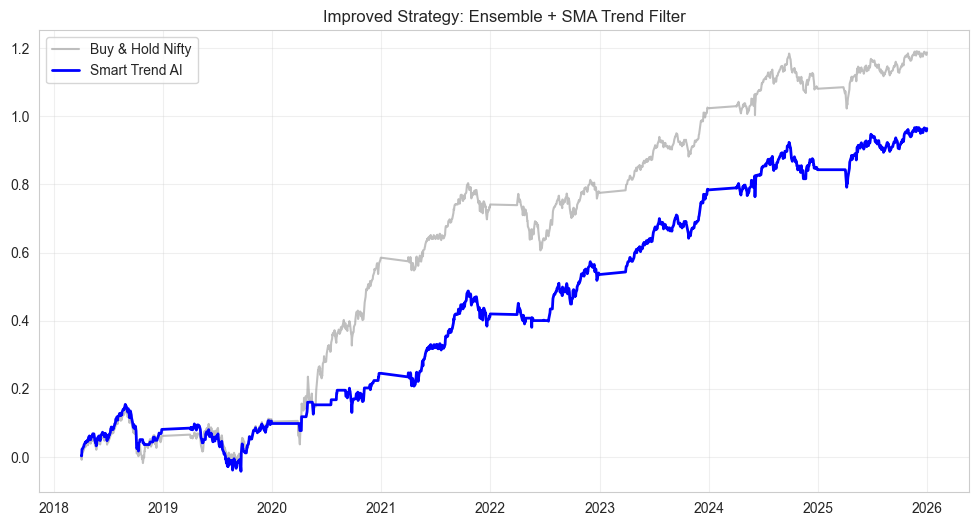

Total Market Return: 227.88%
Total AI Return:     162.25%


In [7]:
# --- CELL 6: Enhanced Strategy Analysis (Long-Only + Trend Filter) ---

# 1. Align Data
res_df['Log_Ret'] = feature_df.loc[res_df.index, 'Log_Ret']
res_df['Close'] = feature_df.loc[res_df.index, 'Close']

# 2. Calculate the Trend Filter (200-day Moving Average)
# We calculate this on the full dataset to ensure we have values at the start of the test
full_sma = feature_df['Close'].rolling(window=200).mean()
res_df['SMA_200'] = full_sma.loc[res_df.index]

# 3. Apply The "Smart Bull" Strategy
# Logic: Nifty goes up over time. We want to be IN the market unless there is danger.
res_df['Signal'] = 0

for i in range(len(res_df)):
    prob = res_df['Prob'].iloc[i]
    price = res_df['Close'].iloc[i]
    sma = res_df['SMA_200'].iloc[i]
    
    # Condition A: Market is Healthy (Price > SMA)
    if price > sma:
        # Be Aggressive: Buy if model is even slightly positive (> 0.50)
        if prob > 0.50:
            res_df['Signal'].iloc[i] = 1
        else:
            res_df['Signal'].iloc[i] = 0 # Cash
            
    # Condition B: Market is in Downtrend (Price < SMA)
    else:
        # Be Defensive: Only buy if model is VERY confident (> 0.60) ("Buying the Dip")
        if prob > 0.60:
            res_df['Signal'].iloc[i] = 1
        else:
            res_df['Signal'].iloc[i] = 0 # Cash (Safety)

# 4. Calculate Returns
res_df['Market_Cum'] = np.cumsum(res_df['Log_Ret'])
res_df['Strategy_Cum'] = np.cumsum(res_df['Signal'] * res_df['Log_Ret'])

# 5. Visuals
plt.figure(figsize=(12, 6))
plt.plot(res_df['Market_Cum'], label='Buy & Hold Nifty', color='gray', alpha=0.5)
plt.plot(res_df['Strategy_Cum'], label='Smart Trend AI', color='blue', linewidth=2)
plt.title("Improved Strategy: Ensemble + SMA Trend Filter")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Final Scorecard
market_ret = np.exp(res_df['Market_Cum'].iloc[-1]) - 1
strat_ret = np.exp(res_df['Strategy_Cum'].iloc[-1]) - 1

print(f"Total Market Return: {market_ret*100:.2f}%")
print(f"Total AI Return:     {strat_ret*100:.2f}%")

In [8]:
# --- CELL 8: Final Production Model Training & Saving ---
# This trains the model on 100% of available data to be ready for live trading.

print("Training Master Model on 100% of Data...")

# 1. Prepare Full Dataset
# We refit the scaler on the entire history to make it as accurate as possible
scaler_rf = RobustScaler()
X_full_rf = scaler_rf.fit_transform(feature_df[RF_COLS])

scaler_lstm = RobustScaler()
X_full_lstm = scaler_lstm.fit_transform(feature_df[LSTM_COLS])

# Create Sequences (Use all data, no test split)
X_seq, y_seq = create_sequences(X_full_lstm, feature_df['Target'].values, SEQ_LENGTH)

# Align RF data (Cut off the start to match LSTM sequence length)
X_rf_aligned = X_full_rf[SEQ_LENGTH:]

# 2. Train the Master Ensemble
master_model = HybridEnsemble(device)
master_model.fit(X_rf_aligned, X_seq, y_seq)

# 3. Save directly to Artifacts Folder
import joblib
import os

ARTIFACTS_DIR = "model_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

torch.save(master_model.lstm.state_dict(), f"{ARTIFACTS_DIR}/production_lstm.pth")
joblib.dump(master_model.rf, f"{ARTIFACTS_DIR}/production_rf.pkl")
joblib.dump(scaler_rf, f"{ARTIFACTS_DIR}/scaler_rf.pkl")
joblib.dump(scaler_lstm, f"{ARTIFACTS_DIR}/scaler_lstm.pkl")

print(f"✅ Master Model & Scalers saved to: {ARTIFACTS_DIR}/")
print("Phase 1 Complete. Ready for Phase 2 or Live Inference.")

Training Master Model on 100% of Data...
✅ Master Model & Scalers saved to: model_artifacts/
Phase 1 Complete. Ready for Phase 2 or Live Inference.
